# Negation and sentiment in BCS

In sentiment analysis tasks, it is essential to account for the occurences of negation: sentences containing negation tend rather to be labelled negative (Wiegand et al. 2010, Jia et al. 2009, Sharif et al. 2016 i. a). Besides sentential negation, the negative markers which may affect the labelling of the sentence, may include narrow scope negation in expressions like "not only" (Jia et al. 2009). The aim of this study is to predict the correct label for the sentences accounting for both wide-scope sentential negation and narrow scope lexical negation in nouns and adjectives (like English un- in "unhappy").

I focus on the data from Bosnian, Croatian, and Serbian languages, uniformly treated as BCS here (the minor differences between those languages are not essential for the analysis) for several main reasons. Firstly, I speak BCS a bit :). Secondly, the extraction of constituent (i.e. narrow scope) negation in BCS is quite intuitive, as well as the extraction of sentential negation: unlike. for instance, English or Greek, Slavic languages have relatively small range of negative markers. In BCS, those are ne- prefix in adjectives/nouns, free-standing sentential "ne", and ne- prefix in auxiliary verbs. Finally, despite the fact that BCS there are some surveys on sentiment analysis on BCS (Ljajić & Marovac 2019, Jahić & Vičič 2023), the influence of constituent negation (especially adjectival and nominal) does not seem to be discussed thoroughly. Not pretending to make a full-fledged research project, I hope to come up with some interesting observations.

This survey explores the corpus of parliamentary debates ParlaSent-BCS v1.0 (https://www.clarin.eu/resource-families/parliamentary-corpora). The corpus contains more than 2,000 sentences collected from parliamentary speech in BCSM. For each sentence, the metadata is provided such as date, number of document, country, the characteristics of the speaker (name, gender, party, etc). Each sentence is annotated by two native speakers as positive, negative or neutral.

In [231]:
#for analysis

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns

In [232]:
#for preprocessing 

import spacy
from spacy import displacy
from collections import Counter
nlp = spacy.load("hr_core_news_sm")

In [233]:
#for machine learning

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

## Explanatory data analysis

Firstly, let us have a look at the dataset

In [234]:
#dataset
df = pd.read_json('ParlaSent-BCS.jsonl', lines=True)

In [235]:
df.head(10)

,sentence,country,round,annotator1,annotator2,reconciliation,label,document_id,sentence_id,date,name,party,gender,birth_year,split
0,Ja shvatam da međunarodna zajednica i oni koji...,BiH,first,Negative,M_Negative,None,Negative,3055,4,19991110,"Špirić, Nikola",SDS,M,1956.0,train
1,"Npr. mene i moje braće, npr. mi tražimo našu i...",BiH,first,Negative,Negative,None,Negative,13704,8,20020417,"Kulenović, Salih",SDA,M,1944.0,test
2,"Pa normalno da nije, ali vidite, pustite kad m...",BiH,first,Negative,Negative,None,Negative,22174,1,20030103,"Lagumdžija, Zlatko",SDP BiH,M,1955.0,train
3,"Pomoći ovim ljudima, da danas ti ljudi mogu i ...",BiH,first,Negative,Negative,None,Negative,28022,13,20040521,"Gligorić, Tihomir",SPRS,M,1955.0,train
4,"Dakle, uz puno uvažavanje, ovo što zna element...",BiH,first,Negative,Negative,None,Negative,34063,15,20050719,"Lagumdžija, Zlatko",SDP BiH,M,1955.0,train
5,"Svi relevantni međunarodni faktori, MMF, Svjet...",BiH,first,Positive,Positive,None,Positive,52453,5,20070613,"Bahtić, Sadik",SBiH,M,1957.0,dev
6,Tačno je da on nije najbolji i tačno je da on ...,BiH,first,M_Positive,Negative,M_Negative,Negative,52659,10,20070613,"Živković, Milorad",SNSD,M,1963.0,train
7,Amandman X. gdje ćemo vidjeti kakva nam je zai...,BiH,first,N_Neutral,N_Neutral,None,Neutral,55190,14,20071011,"Bećirović, Denis",SDP BiH,M,1975.0,test
8,Ovaj odgovor će gospodin zastupnik dobiti prec...,BiH,first,N_Neutral,N_Neutral,None,Neutral,70966,2,20091014,"Čolak, Bariša",None,None,NaN,train
9,"Gospodine Ljubiću, Vi pripadate grupi samoprog...",BiH,first,Negative,Negative,None,Negative,85628,6,20111222,"Dervoz, Ismeta",SBB,F,1954.0,train


Besides the very text of the sentence, there is some meta-information on the speakers (name, date of birth, gender, party affiliation, etc), as well as the country: Bosnia and Herzegivina, Croatia or Serbia. The column "split" indicates whether the sentence belonged to the train/validation set or to the test set in the original dataset (I do not plan to pay attention to this division, and will resplit it by myself randomly).

In [236]:
print('The size of the data: ', df.shape) #rows, columns

The size of the data:  (2600, 15)


Count the unique values for each variable

In [237]:
df.nunique()

sentence          2595
country              3
round                2
annotator1           6
annotator2           6
reconciliation       6
label                3
document_id       2540
sentence_id        132
date              1442
name               877
party               77
gender               2
birth_year          57
split                3
dtype: int64

Check for null values

In [238]:
df.isna().sum()

sentence             0
country              0
round                0
annotator1        1300
annotator2           0
reconciliation    2393
label                0
document_id          0
sentence_id          0
date                 0
name                 0
party              338
gender             225
birth_year         225
split                0
dtype: int64

Among all of the variables, only two are essential for us: the sentence (namely, the linguistic content) and the final label. Fortunately, no NAs are found in these columns.

Let's figure out the distribution of labels in the data.

In [239]:
neg_sents = df[df['label'] == 'Negative']['sentence'] #only sentences labeled negative
pos_sents = df[df['label'] == 'Positive']['sentence'] #only sentences labeled positive
neut_sents = df[df['label'] == 'Neutral']['sentence'] #only sentences labeled neutral

In [240]:
print('Negative:', len(neg_sents))
print('Positive:', len(pos_sents))
print('Neutral:', len(neut_sents))

Negative: 1358
Positive: 470
Neutral: 772


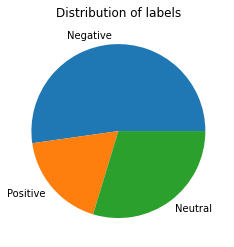

In [241]:
labels = 'Negative', 'Positive', 'Neutral'
sizes = [len(neg_sents), len(pos_sents), len(neut_sents)]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels)
plt.title('Distribution of labels')
plt.show()

Both positive and neutral sentences together form about a half of the data. Negative sentences form another half of the data. Given that positive and neutral sentences are fairly uncommon in comparison to negative sentences, I would focus on binary classification: negative vs non-negative sentences (i.e. I would treat neutral and positive sentences uniformly)

It may be useful to check how balanced data is. Let us review the distribution of labels across countries:

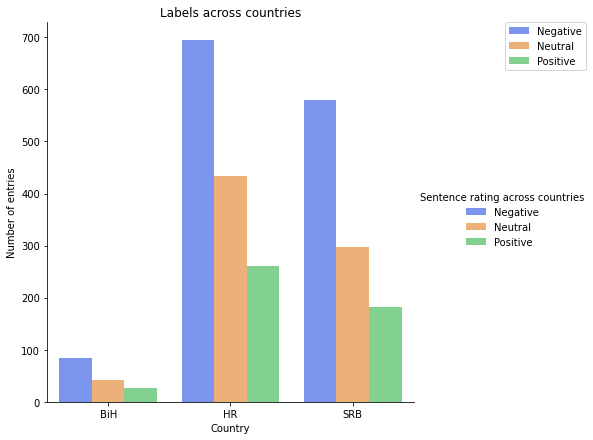

In [242]:
grouped = df.groupby(['country', 'label'], as_index=False).agg({'sentence':'count'}).rename(columns={'sentence':'entries'})

g = sns.catplot(data=grouped, kind="bar", x="country", y="entries", hue="label", 
                palette="bright", alpha=.6, height=6).set(title='Labels across countries')
#g.despine(left=True)
g.set_axis_labels("Country", "Number of entries")
g.legend.set_title("Sentence rating across countries")
plt.legend(bbox_to_anchor=(1.25, 1), loc=2, borderaxespad=0.)
plt.show()

Across all three countries, negative rated sentences seem to prevail. Are there any imbalances due to gender?

The vast majority of speech is produced by male deputies, so the heatmap is normalized: it shows which fraction of the whole amount of sentences uttered by female/male representatives have a given label. However, as seen from the following plot, three labels are distributed similarly across the genders:

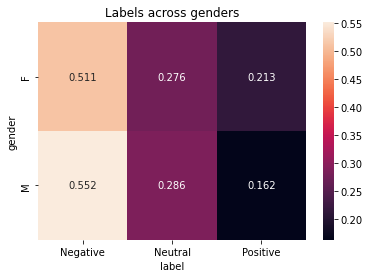

In [243]:
gend = df.dropna(subset=['gender']).\
            groupby(['gender', 'label'], as_index=False).\
            agg({'sentence':'count'}).\
            pivot(index='gender', columns='label', values='sentence')

gend = gend.div(gend.sum(axis=1), axis=0)

sns.heatmap(gend, annot=True, fmt=".3f").set(title='Labels across genders')
plt.show()

Negative sentences prevail in speech of both female and male speakers, so the data is relatively balanced with respect to gender and country variables. Finally, let's look at the distribution of labels among parties. I tend to hypothesise that the majority of positive statements will come from the ruling parties, while the majority of negative ones from the opposition.

In [244]:
#Grouping the data by parties

def group_by_parties(df):
    return df.groupby(['party', 'label'], as_index=False).agg({'sentence':'count'}).rename(columns={'sentence':'count'})

bih = group_by_parties(df[df['country']=='BiH'])
hr = group_by_parties(df[df['country']=='HR'])
srb = group_by_parties(df[df['country']=='SRB'])

In [245]:
#making a pivot table and a plot

def build_pivot(df, countryname):
    pvt = df.pivot_table(values='count', index='label', columns='party').fillna(0)
    pvt = pvt.div(pvt.sum(axis=1), axis=0)
    plt = pvt.reset_index().plot(x = 'label', kind = 'barh', stacked = True, 
                                 title = 'Labels by parties: {}'.format(countryname), mark_right = True)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt

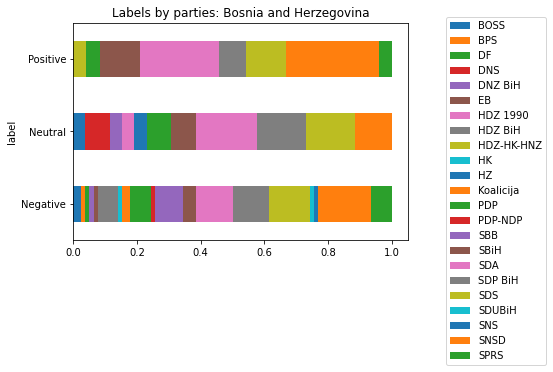

In [246]:
build_pivot(bih, 'Bosnia and Herzegovina')

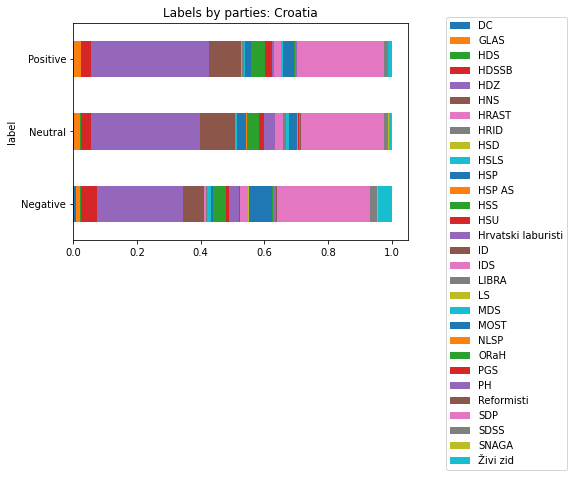

In [247]:
build_pivot(hr, 'Croatia')

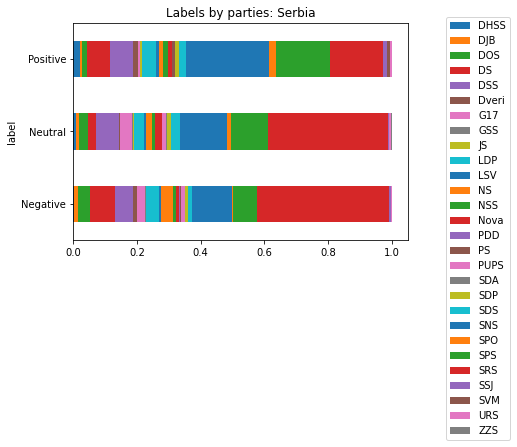

In [248]:
build_pivot(srb, 'Serbia')

The hypothesis is confirmed for Croatia and Serbia. As HDZ and SNS are conservative parties ruling for years, they tend to talk about some positive stuff more than others. Among the greatest "negative" speakers, there are Serbian SRS (radical nationalists) and Croatian Social-Democratic party (the second party in the contry). Some populists also tend to produce negative sentences, like Croatian MOST.

Probably, party is an only variable, besides text, which could be useful for label prediction. However, our task is a bit different and, fortunately, the political association does not explain the whole distribution. Let us explore the text data.

## Negation: count

Now let's initialize the function which detects if the word contains a negative marker, and if it does, which type of negation it belongs to. If it is a wide-scope negation, i. e. a verbal negation, including negative auxilliaries, it assigns 1. If it is a narrow-scope negation, which takes not verb but adjective or noun in its scope, it assigns 2. If there are no negative elements, it assigns 0.

As a result, the word "nisu", which is the negative form of the copular verb "biti" (form for third person plural), will be labeled 1, while the word "nesretan" (unhappy) will be labeled 2. For POS tagging, I used the spacy model for Croatian (initialized at the beginning of the notebook as nlp).

In [249]:
def detect_neg(sentence_series):
    sents = []
    for s in sentence_series:
        words = []
        doc = nlp(s) #spacy for pos tagging POS tagger
        for p in [(X.text, X.pos_) for X in doc]:
            neg = 0
            if p[1] == 'AUX' and p[0].startswith('ni'):
                neg = 1
            elif p[0] == 'ne':
                neg = 1
            elif p[0] == 'ne':
                neg = 1
            elif p[1] in ('NOUN', 'ADJ') and p[0].startswith('ne'):
                neg = 2
            neg_tuple = (neg,)
            p = p + neg_tuple
            words.append(p)
        sents.append(words)
    return sents

When applied to arrays containing sentences, the function returns the list of tuples containing the word and its part of speech tag.

In [250]:
neg_arrays = detect_neg(neg_sents)
pos_arrays = detect_neg(pos_sents)
neut_arrays = detect_neg(neut_sents)

In [251]:
#each tuple contains a word, its POS tag, and the label of negative marker

for arr in neg_arrays[:5]:
    for t in arr:
        print(t)
    print('\n')

('Ja', 'PRON', 0)
('shvatam', 'VERB', 0)
('da', 'SCONJ', 0)
('međunarodna', 'ADJ', 0)
('zajednica', 'NOUN', 0)
('i', 'CCONJ', 0)
('oni', 'DET', 0)
('koji', 'DET', 0)
('su', 'AUX', 0)
('pomagali', 'VERB', 0)
('ovome', 'DET', 0)
('guraju', 'VERB', 0)
('najjeftiniji', 'ADJ', 0)
('projekat', 'NOUN', 0)
('zato', 'SCONJ', 0)
('što', 'SCONJ', 0)
('nema', 'VERB', 0)
('sredstava', 'NOUN', 0)
('za', 'ADP', 0)
('sve', 'ADJ', 0)
('segmente', 'NOUN', 0)
('.', 'PUNCT', 0)
('za', 'ADP', 0)
('uređenje', 'NOUN', 0)
('i', 'CCONJ', 0)
('demokratizaciju', 'NOUN', 0)
('BiH', 'PROPN', 0)
('u', 'ADP', 0)
('cjelini', 'NOUN', 0)
('.', 'PUNCT', 0)


('Npr', 'PART', 0)
('.', 'PART', 0)
('mene', 'PRON', 0)
('i', 'CCONJ', 0)
('moje', 'ADJ', 0)
('braće', 'NOUN', 0)
(',', 'PUNCT', 0)
('npr', 'PART', 0)
('.', 'PART', 0)
('mi', 'PRON', 0)
('tražimo', 'VERB', 0)
('našu', 'DET', 0)
('imovinu', 'NOUN', 0)
('od', 'ADP', 0)
('29.1.1996.godine', 'NUM', 0)
('do', 'ADP', 0)
('20.3.2002.godine', 'NOUN', 0)
('.', 'PUNCT', 0)




Now each sentence may be represented as a vector where 0 corresponds to a non-negative word and 1 or 2 corresponds to a negative element. Let's see it for the first twenty sentences of each subdataset.

In [252]:
#neg

for arr in neg_arrays[:20]:
    print([t[2] for t in arr])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 

In [253]:
#pos

for arr in pos_arrays[:20]:
    print([t[2] for t in arr])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0

In [254]:
#neut

for arr in neut_arrays[:20]:
    print([t[2] for t in arr])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

What is interesting for us now is what is the ratio of sentences containing (any) negative marker among negative, positive, and neutral sentences. It is performed with the following function:

In [255]:
def count_neg(arrs):
    neg_sents = 0
    for arr in arrs:
        if 1 in [t[2] for t in arr] or 2 in [t[2] for t in arr]: #if the sentence contains either sentential or constituent neg
            neg_sents += 1
    return neg_sents

In [256]:
print('Negative sentences with negation: ', count_neg(neg_arrays)/len(neg_arrays))
print('Positive sentences with negation: ',count_neg(pos_arrays)/len(pos_arrays))
print('Neutral sentences with negation: ',count_neg(neut_arrays)/len(neut_arrays))

Negative sentences with negation:  0.4631811487481591
Positive sentences with negation:  0.16595744680851063
Neutral sentences with negation:  0.18911917098445596


Let's visualize it now

In [257]:
def build_pie(arrays):
    x = np.array([count_neg(arrays)/len(arrays), 1 - count_neg(arrays)/len(arrays)])
    plt.pie(x, labels = ['Negation', 'No negation'])
    plt.show()

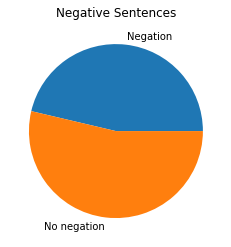

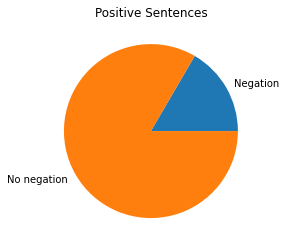

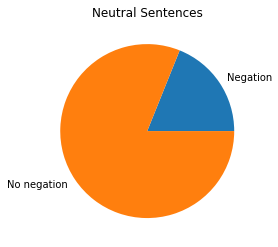

In [258]:
plt.title('Negative Sentences')
build_pie(neg_arrays)

plt.title('Positive Sentences')
build_pie(pos_arrays)

plt.title('Neutral Sentences')
build_pie(neut_arrays)

We can already see that it is way more typically for the sentences labeled negative to contain negative markers than for the sentences labeled positive and neutral.

What can we say on two types of negation? Does the distribution differ for sentential negation and constituent negation? Let's figure it out with the following function.

In [259]:
def count_all_neg(arrs):
    sent_neg = 0
    const_neg = 0
    both_neg = 0
    no_neg = 0
    for arr in arrs:
        if 1 in [t[2] for t in arr]:
            if 2 in [t[2] for t in arr]:
                both_neg += 1 #for sentences containing both constituent and sentential negation
            else:
                sent_neg += 1 #for sentences containing sentential negation only
        elif 2 in [t[2] for t in arr]:
            const_neg += 1 #for sentences containing constituent negation only
        else:
            no_neg += 1 #for sentences without any negation
    return np.array([no_neg, sent_neg, const_neg, both_neg])

In [260]:
def build_another_pie(arrays):
    plt.pie(count_all_neg(arrays), 
            labels = ['No negation', 'Sentential  Negation', 'Constituent negation', 'Both types of negation'])
    plt.show()

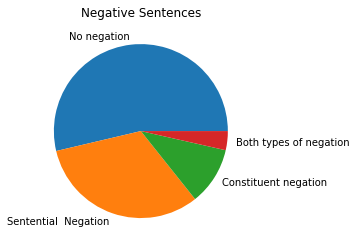

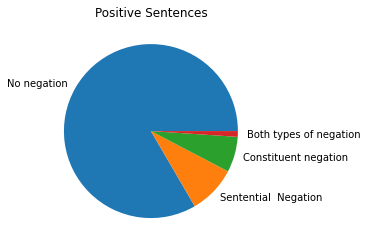

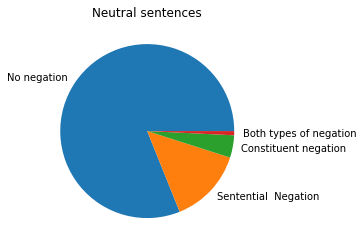

In [261]:
plt.title('Negative Sentences')
build_another_pie(neg_arrays)

plt.title('Positive Sentences')
build_another_pie(pos_arrays)

plt.title('Neutral sentences')
build_another_pie(neut_arrays)

Thus, both constituent and sentential negation have a greater proportion among the negative sentences.

There are still some things to check though. Could there possibly be some other grammatical features which tend to occur in negative-labeled sentences? What if there is an influence of the distribution of parts of speech?

In [262]:
#this function counts parts-of-speech

def count_pos(arr):
    bag=[]
    for sent in arr:
        for word in sent:
            bag.append(word[1])
    return(Counter(bag))

In [263]:
#getting POS-dictionaries
pos_negative = count_pos(neg_arrays)
pos_neutral = count_pos(neut_arrays)
pos_positive = count_pos(pos_arrays)

#sorting dictionaries by keys
sorted_ng = sorted(list(pos_negative.keys()))
sorted_neu = sorted(list(pos_neutral.keys()))
sorted_ps = sorted(list(pos_positive.keys()))

#making dictionaries to build a dataframe
pos_negative = {k : pos_negative[k] for k in sorted_ng}
pos_neutral = {k : pos_neutral[k] for k in sorted_neu}
pos_positive = {k : pos_positive[k] for k in sorted_ps}

In [264]:
print('Negative sentences: ', pos_negative)
print('Neutral sentences: ', pos_neutral)
print('Positive sentences: ', pos_positive)

Negative sentences:  {'ADJ': 3182, 'ADP': 2429, 'ADV': 1954, 'AUX': 2243, 'CCONJ': 1712, 'DET': 2089, 'INTJ': 9, 'NOUN': 6991, 'NUM': 348, 'PART': 719, 'PRON': 1659, 'PROPN': 917, 'PUNCT': 3459, 'SCONJ': 1562, 'SYM': 42, 'VERB': 3523, 'X': 28}
Neutral sentences:  {'ADJ': 2068, 'ADP': 1521, 'ADV': 815, 'AUX': 984, 'CCONJ': 791, 'DET': 854, 'INTJ': 2, 'NOUN': 4349, 'NUM': 232, 'PART': 207, 'PRON': 643, 'PROPN': 405, 'PUNCT': 1714, 'SCONJ': 550, 'SYM': 42, 'VERB': 1483, 'X': 10}
Positive sentences:  {'ADJ': 1355, 'ADP': 907, 'ADV': 617, 'AUX': 700, 'CCONJ': 735, 'DET': 696, 'NOUN': 2810, 'NUM': 117, 'PART': 109, 'PRON': 509, 'PROPN': 296, 'PUNCT': 1104, 'SCONJ': 474, 'SYM': 23, 'VERB': 1139, 'X': 5}


In [265]:
pos_df = pd.DataFrame([pos_positive, pos_neutral, pos_negative], index=['pos', 'neut', 'neg']).fillna(0)
pos_df.head()

,ADJ,ADP,ADV,AUX,CCONJ,DET,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X,INTJ
pos,1355,907,617,700,735,696,2810,117,109,509,296,1104,474,23,1139,5,0.0
neut,2068,1521,815,984,791,854,4349,232,207,643,405,1714,550,42,1483,10,2.0
neg,3182,2429,1954,2243,1712,2089,6991,348,719,1659,917,3459,1562,42,3523,28,9.0


What is the relative frequency of each POS?

In [266]:
rel_pos_df = pos_df.div(pos_df.sum(axis=1), axis=0)
rel_pos_df

,ADJ,ADP,ADV,AUX,CCONJ,DET,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X,INTJ
pos,0.116851,0.078217,0.053208,0.060366,0.063384,0.060021,0.242325,0.010090,0.009400,0.043894,0.025526,0.095205,0.040876,0.001983,0.098224,0.000431,0.000000
neut,0.124055,0.091242,0.048890,0.059028,0.047451,0.051230,0.260888,0.013917,0.012418,0.038572,0.024295,0.102819,0.032993,0.002519,0.088962,0.000600,0.000120
neg,0.096817,0.073906,0.059454,0.068247,0.052090,0.063561,0.212712,0.010588,0.021877,0.050478,0.027901,0.105246,0.047526,0.001278,0.107193,0.000852,0.000274


Now let's build a map. As we can see, there are no signiificant imbalancies between sentences labeled differently.

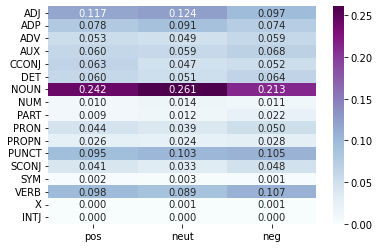

In [267]:
sns.heatmap(rel_pos_df.transpose(), annot=True, fmt=".3f", cmap='BuPu')
plt.show()

## Modeling

We managed to find out that negative markers mostly occur in negative-labeled sentences. Now it is turn to implement the hypothesis into a model.

I am going to use two classic approaches to sentiment analysis: bag-of-words and tf-idf approach. Each approach will be tested in three versions: a vanilla one (with no regard to negation, with all stopwords removed, including negative ones), the one with account for sentential negation, and the one with account for both sentential and constituent negation.

### Bag-of-words sentiment analysis (vanilla)

In [268]:
#stopwords for BCS

stopwords = nlp.Defaults.stop_words
print(stopwords)

{'ovoj', 'deder', 'nema', 'hoće', 'još', 'bila', 'njim', 'nisu', 'htjedoh', 'doskoro', 'svog', 'meni', 'hura', 'željeo', 'bar', 'bijahu', 'moj', 'ovim', 'eto', 'bih', 'niste', 'uz', 'njihov', 'nećeš', 'htijasmo', 'je', 'de', 'ova', 'hej', 'u', 'sam', 'tvoj', 'djelomice', 'naše', 'mimo', 'njegova', 'svoja', 'ono', 'šta', 'mene', 'tako', 'eno', 'bijasmo', 'budući', 'želeći', 'moji', 'tada', 'zaista', 'moju', 'vam', 'gic', 'on', 'biste', 'gdjekoje', 'željeni', 'njezino', 'no', 'se', 'jesu', 'vama', 'prije', 'ponekad', 'svi', 'sebi', 'ta', 'vi', 'bio', 'čijim', 'njemu', 'ehe', 'pa', 'bude', 'al', 'dem', 'vjerovatno', 'željen', 'zum', 'već', 'vrh', 'ako', 'vjerojatno', 'moja', 'ikakvome', 'bili', 'evo', 's', 'na', 'oni', 'za', 'su', 'ni', 'htjeli', 'duž', 'naš', 'uzagrapce', 'kojima', 'ikakvom', 'zatim', 'jest', 'pored', 'njezina', 'tima', 'naša', 'im', 'bez', 'štogod', 'onoj', 'god', 'vašim', 'svoju', 'joj', 'do', 'njezin', 'au', 'iju', 'željela', 'ikakvih', 'će', 'po', 'o', 'čijem', 'mi',

Next, we shuffle the dataframe and initialize the corpus of texts to X variable, and the label vector to y. 

In [269]:
data = shuffle(df)

X = data['sentence']
data['label'].replace({'Neutral': 0, 'Positive': 0, 'Negative': 1}, inplace=True)
y = data['label']

In [270]:
data.tail(5)

,sentence,country,round,annotator1,annotator2,reconciliation,label,document_id,sentence_id,date,name,party,gender,birth_year,split
479,Kad su u pitanju droga i alkohol naravno da tu...,HR,first,Negative,Negative,None,1,64471,19,20101201,"Stazić, Nenad",SDP,M,1957.0,test
1004,Naš lider dr Vojislav Šešelj se borio i danas ...,SRB,first,Positive,Positive,None,0,16320,7,20090325,"Plužarević, Vitomir",SRS,M,1950.0,test
372,Nato savez tu se vjerojatno svi slažemo je prv...,HR,first,P_Neutral,P_Neutral,None,0,79328,51,20061207,"Kajin, Damir",IDS,M,1962.0,train
2116,"Ne, podsetio bih vas, da i u Drugom svetskom r...",SRB,second,None,P_Neutral,None,0,17204,16,20170526,"Lazanski, Miroslav",SNS,M,1950.0,train
914,"Mi žalimo zbog ubistva Đinđića, ali su ga ubil...",SRB,first,Negative,Negative,None,1,7471,10,20041027,"Dačić, Ivica",SPS,M,1966.0,dev


In [271]:
X.tail(5)

479     Kad su u pitanju droga i alkohol naravno da tu...
1004    Naš lider dr Vojislav Šešelj se borio i danas ...
372     Nato savez tu se vjerojatno svi slažemo je prv...
2116    Ne, podsetio bih vas, da i u Drugom svetskom r...
914     Mi žalimo zbog ubistva Đinđića, ali su ga ubil...
Name: sentence, dtype: object

In [272]:
y.tail(5)

479     1
1004    0
372     0
2116    0
914     1
Name: label, dtype: int64

To make the computations run, we must apply the vectorizer to the data, either Count Vectorizer (for BoW) or TF-IDF Vectorizer. Here comes the function:

In [273]:
def vectorize(vectorizer, stopwords, df):
    vec = vectorizer(stop_words=stopwords)
    df_transformed = vec.fit_transform(df)
    return pd.DataFrame(df_transformed.toarray(), columns = vec.get_feature_names())

In [274]:
X_plain = vectorize(CountVectorizer, stopwords, X)

C:\Users\denis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [275]:
print('The dataframe contains data of {0} sentences accounting with the total of {1} words'.format(*(X_plain.shape)))

The dataframe contains data of 2600 sentences accounting with the total of 12834 words


In [276]:
X_train, X_test, y_train, y_test = train_test_split(X_plain, y, test_size=0.2, random_state=100)

In [277]:
X_train.head()

,00,000,01,02,10,100,1000,100000,101,106,...,županiji,županijsko,županijskog,županiju,žurbu,žustru,žuti,žutilom,žutu,ѕdžc
2556,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1572,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
190,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
924,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1957,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The dataframe contains no stopwords, neither positive nor negative auxiliaries can be found there. 

In [278]:
'bismo' in X_train.columns #AUX, 1SG

False

In [279]:
'nismo' in X_train.columns #sent neg

False

Usual lexemes are all here:

In [280]:
'srbija' in X_train.columns

True

Things we need the most for the analysis are the classification algorithm (for our binary classification task, I am going to test logistic regression, decision tree, and SVM classifier), a quality metric (I will use accuracy as the main metric and F1-score to check if there is no particular problems like under- or overfitting), and a confusion matrix to visualize the First-Type and Second-Type Errors. The following function does all of these tasks.

In [281]:
def EvaluatePerformance(Classifier, X_train, y_train, X_test, y_test):
    Classifier.fit(X_train, y_train) #fit the clf to the train data
    y_pred = Classifier.predict(X_test) #predict the labels of the test sets
    print('Training set score: {:2f}'.format(Classifier.score(X_train, y_train))) #training score (should be large)
    print('Average test set score: {:2f}'.format(Classifier.score(X_test, y_test))) #test score (should be not so large)
    print('F1-score: {:2f}'.format(f1_score(y_test, y_pred))) #the precision/recall balance in the test predictions
    cm = confusion_matrix(y_test, y_pred, normalize='all')
    cm_display = ConfusionMatrixDisplay(cm).plot()
    return Classifier

Training set score: 0.998077
Average test set score: 0.651923
F1-score: 0.673874


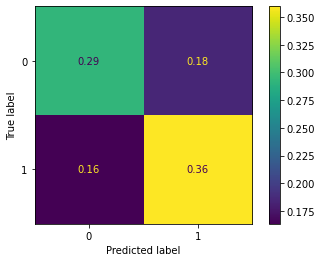

In [282]:
logreg = EvaluatePerformance(LogisticRegression(), X_train, y_train, X_test, y_test)

Training set score: 1.000000
Average test set score: 0.567308
F1-score: 0.625624


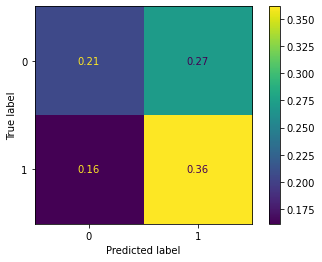

In [283]:
dt = EvaluatePerformance(DecisionTreeClassifier(), X_train, y_train, X_test, y_test)

Training set score: 1.000000
Average test set score: 0.625000
F1-score: 0.648649


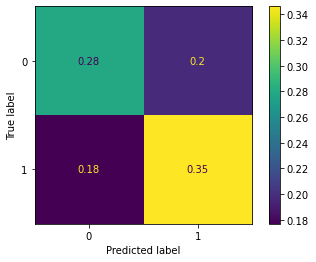

In [284]:
sv = EvaluatePerformance(svm.LinearSVC(), X_train, y_train, X_test, y_test)

### Bag-of-words with sentential negation

Now, our dataframe will contain a column indicating if the sentence contains a sentential negation (i.e. either "ne" or negated auxiliary)

In [285]:
#list of stopwords but without sentential negation

noneg_stopwords = []
for word in stopwords:
    if not word.startswith('ni') and word != 'ne':
        noneg_stopwords.append(word)

In [286]:
X_sent_neg = vectorize(CountVectorizer, noneg_stopwords, X)

C:\Users\denis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [287]:
'nismo' in X_sent_neg.columns

True

Now we have negated aux in the data! Let's now remove the separate columns for negative markers and add one column showing whether there is a negative marker or not.

In [288]:
def AddSentNeg(df):
    df['is_sent_neg'] = np.where(((df['ne'] > 0) | (df['nisam'] > 0) | \
                                  (df['nisi'] > 0) | (df['nije'] > 0)| \
                                  (df['nismo'] > 0) | (df['niste'] > 0)| \
                                  (df['nisu'] > 0)), 1, 0)
    df = df.drop(columns=['ne', 'nisam', 'nisi', 'nije', 'nismo', 'niste', 'nisu'])
    return df

In [289]:
X_sent_neg = AddSentNeg(X_sent_neg)

In [290]:
X_sent_neg['is_sent_neg'].value_counts()

0    1909
1     691
Name: is_sent_neg, dtype: int64

We have no negative words in the data anymore:

In [291]:
'nismo' in X_sent_neg.columns

False

Now we are coming to predictions

In [292]:
X_train, X_test, y_train, y_test = train_test_split(X_sent_neg, y, test_size=0.2, random_state=100)

Training set score: 0.997115
Average test set score: 0.667308
F1-score: 0.676636


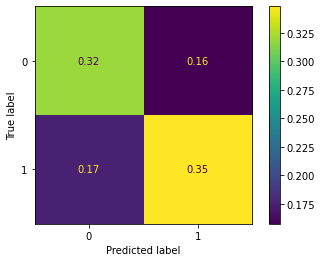

In [293]:
logreg1 = EvaluatePerformance(LogisticRegression(), X_train, y_train, X_test, y_test)

Training set score: 1.000000
Average test set score: 0.611538
F1-score: 0.617424


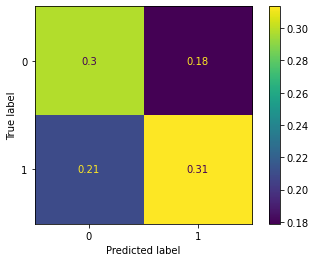

In [294]:
dt1 = EvaluatePerformance(DecisionTreeClassifier(), X_train, y_train, X_test, y_test)

Training set score: 1.000000
Average test set score: 0.634615
F1-score: 0.649446


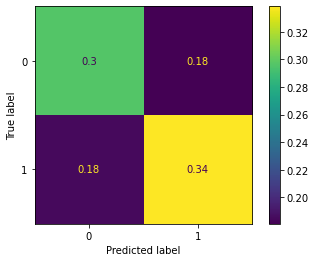

In [295]:
sv1 = EvaluatePerformance(svm.LinearSVC(), X_train, y_train, X_test, y_test)

For all the algorithms (maybe except SVM on some tests), the model seems to perform better! Now, we are looking at the constituent negation.

### Bag-of-words with sentential and constituent negation

Initialize a list of negative adjectives and nouns:

In [296]:
const_neg = []

for name in X_plain.columns:
    if name.startswith('ne'):
        if nlp(name)[0].pos_ == 'ADJ' or nlp(name)[0].pos_ == 'NOUN':
            const_neg.append(name)

print('There are {} negative adjectives'.format(len(const_neg)))

There are 232 negative adjectives


In [297]:
print(const_neg[:10])

['nebojšinu', 'nebrige', 'nebrojeno', 'nedavne', 'nedavnih', 'nedavnog', 'nedemokratskim', 'nedjeljom', 'nedobitna', 'nedopustiva']


The following function will drop the columns corresponding to negative nouns and adjectives (i.e. the items with constituent negation) and add a column 'is_const' which will show whether such an item is present in a sentence or not (as 'is_sent' showed it for wide-scope negation)

In [298]:
def AddConstNeg(df):
    df['is_const_neg'] = np.where((df[const_neg] > 0).any(axis=1), 1, 0)
    return df.drop(const_neg, axis=1)

In [299]:
X_all_neg = X_sent_neg.copy()
X_all_neg = AddConstNeg(X_all_neg)

In [300]:
X_all_neg['is_const_neg'].value_counts()

0    2318
1     282
Name: is_const_neg, dtype: int64

Are there negative adjectives?

In [301]:
'nebojšinu' in X_all_neg.columns

False

If no, let's turn to predictions

In [302]:
X_train, X_test, y_train, y_test = train_test_split(X_all_neg, y, test_size=0.2, random_state=100)

Training set score: 0.996154
Average test set score: 0.667308
F1-score: 0.684882


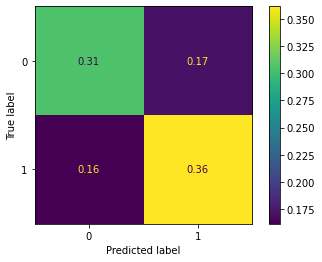

In [303]:
logreg2 = EvaluatePerformance(LogisticRegression(), X_train, y_train, X_test, y_test)

Training set score: 1.000000
Average test set score: 0.640385
F1-score: 0.656881


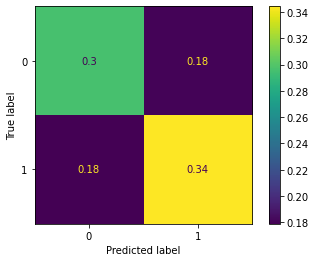

In [304]:
dt2 = EvaluatePerformance(DecisionTreeClassifier(), X_train, y_train, X_test, y_test)

Training set score: 1.000000
Average test set score: 0.636538
F1-score: 0.651934


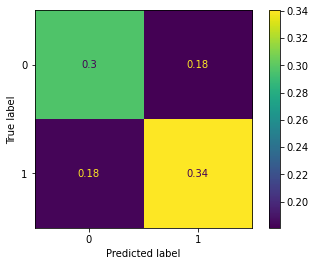

In [305]:
sv2 = EvaluatePerformance(svm.LinearSVC(), X_train, y_train, X_test, y_test)

We can see that for different algorithms, adding constituent negation parameter has different effects: while SVM usually performs better, decision tree and logistic regression usually do not improve with this condition.

### TF-IDF approach (vanilla)

TF-IDF approach has a chance to outperform the classic BoW given that it takes the local significance of each word into account. How does it perform on our data?

In the following chuncks, we are going to do the same actions and apply the same classification algorithms, but with different encoder

In [306]:
X_tfidf_plain = vectorize(TfidfVectorizer, stopwords, X)

C:\Users\denis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [307]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_plain, y, test_size=0.2, random_state=100)

Training set score: 0.976442
Average test set score: 0.651923
F1-score: 0.704731


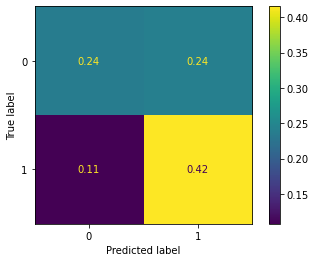

In [308]:
tf_logreg = EvaluatePerformance(LogisticRegression(), X_train, y_train, X_test, y_test)

Training set score: 1.000000
Average test set score: 0.544231
F1-score: 0.590674


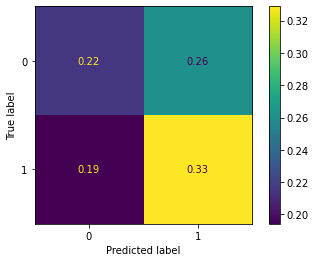

In [309]:
tf_dt = EvaluatePerformance(DecisionTreeClassifier(), X_train, y_train, X_test, y_test)

Training set score: 1.000000
Average test set score: 0.650000
F1-score: 0.684028


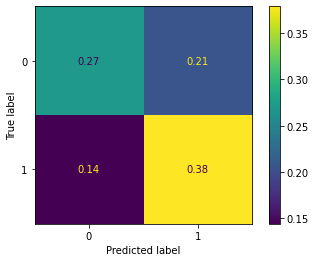

In [310]:
tf_sv = EvaluatePerformance(svm.LinearSVC(), X_train, y_train, X_test, y_test)

It goes fairly well!

### TF-IDF with sentential negation

In [311]:
X_tfidf_sent_neg = vectorize(TfidfVectorizer, noneg_stopwords, X)

C:\Users\denis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [312]:
X_tfidf_sent_neg = AddSentNeg(X_tfidf_sent_neg)

In [313]:
X_tfidf_sent_neg['is_sent_neg'].value_counts()

0    1909
1     691
Name: is_sent_neg, dtype: int64

In [314]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_sent_neg, y, test_size=0.2, random_state=100)

Training set score: 0.906250
Average test set score: 0.663462
F1-score: 0.634656


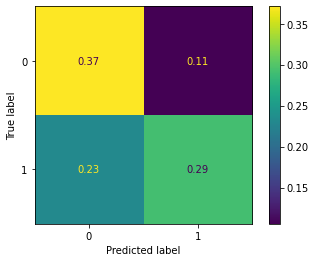

In [315]:
tf_logreg1 = EvaluatePerformance(LogisticRegression(), X_train, y_train, X_test, y_test)

Training set score: 1.000000
Average test set score: 0.613462
F1-score: 0.597194


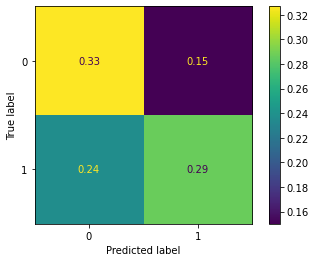

In [316]:
tf_dt1 = EvaluatePerformance(DecisionTreeClassifier(), X_train, y_train, X_test, y_test)

Training set score: 1.000000
Average test set score: 0.653846
F1-score: 0.666667


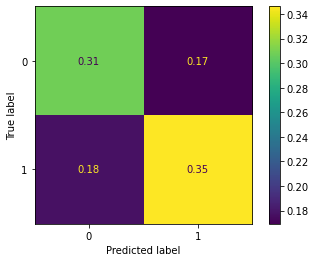

In [317]:
tf_sv1 = EvaluatePerformance(svm.LinearSVC(), X_train, y_train, X_test, y_test)

Apparently, on the majority of tests all three classifiers show better score. Let's turn to constituent negation

### TF-IDF with sentential and constituent negation

In [318]:
X_tfidf_all_neg = X_tfidf_sent_neg.copy()

In [319]:
X_tfidf_all_neg = AddConstNeg(X_tfidf_all_neg) 

In [320]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_all_neg, y, test_size=0.2, random_state=100)

Training set score: 0.874038
Average test set score: 0.661538
F1-score: 0.646586


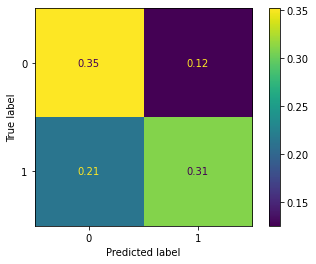

In [321]:
tf_logreg2 = EvaluatePerformance(LogisticRegression(), X_train, y_train, X_test, y_test)

Training set score: 1.000000
Average test set score: 0.630769
F1-score: 0.634981


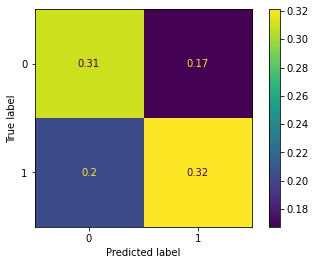

In [322]:
tf_dt2 = EvaluatePerformance(DecisionTreeClassifier(), X_train, y_train, X_test, y_test)

Training set score: 1.000000
Average test set score: 0.671154
F1-score: 0.689655


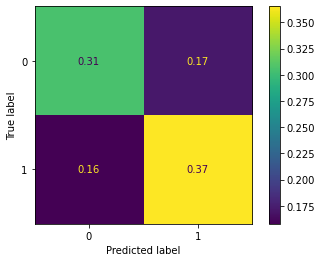

In [323]:
tf_sv2 = EvaluatePerformance(svm.LinearSVC(), X_train, y_train, X_test, y_test)

As in the case of BoW, logreg and decision tree do not face any positive changes. However, SVM tend to improve its score in the majority of tests. As a result, we claim the SVM TF-IDF model applied to all-negation dataset a winner.

Could we tune it though?

# Tuning the best model: GridSearch

SVM has several hyperparameters: the regularization function used to avoid overfitting (either l1 or l2 regularization are available) and C parameter, which, conversely, reduces the strength of regularization to some extent. There are also several ways to compute loss function and update weights. What if we could improve our original score testing it with different hyperparameters?

Let us implement the GridSearch algorithm to find best parameters

In [324]:
params = {"C":np.arange(0.1, 1.1, 0.1), 'penalty':['l1', 'l2'], 'loss':['hinge', 'squared_hinge'],
          "class_weight":['balanced', 'None']} 
#parameters to tune

Fist, recall what the algorithm had shown before tuning:

Training set score: 1.000000
Average test set score: 0.671154
F1-score: 0.689655


LinearSVC()

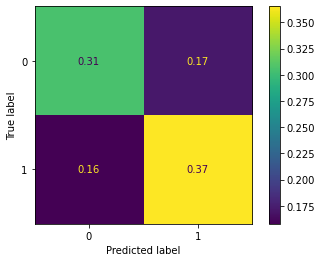

In [325]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_all_neg, y, test_size=0.2, random_state=100)
EvaluatePerformance(svm.LinearSVC(), X_train, y_train, X_test, y_test)

In [326]:
svm_cv

GridSearchCV(cv=10, estimator=LinearSVC(),
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'class_weight': ['balanced', 'None'],
                         'loss': ['hinge', 'squared_hinge'],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [327]:
svm_cv = GridSearchCV(svm.LinearSVC(), params, cv=10, scoring = 'accuracy')
svm_cv.fit(X_train,y_train)

C:\Users\denis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
600 fits failed out of a total of 800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\denis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\denis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "C:\Users\denis\AppData\Local\Programs\Python\Python39\lib\s

GridSearchCV(cv=10, estimator=LinearSVC(),
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'class_weight': ['balanced', 'None'],
                         'loss': ['hinge', 'squared_hinge'],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [328]:
print('Best parameters: ', svm_cv.best_params_)
print('Best score: ', svm_cv.best_score_)

Best parameters:  {'C': 0.5, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'penalty': 'l2'}
Best score:  0.685576923076923


Let's apply it to the test data

Average test set score: 0.667308
F1-score: 0.676636


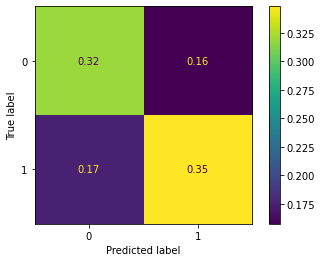

In [329]:
clf = svm_cv.best_estimator_

y_pred = clf.predict(X_test)
print('Average test set score: {:2f}'.format(clf.score(X_test, y_test)))
print('F1-score: {:2f}'.format(f1_score(y_test, y_pred)))

cm = confusion_matrix(y_test, y_pred, normalize='all')
ConfusionMatrixDisplay(cm).plot()

Seems, it did not improve. At least, I tried

<img src="https://i.imgur.com/HIJ2EXu.jpeg"/>

## Concluding remarks

It seems that taking the elements with constituent negation into account may be useful in sentiment analysis task. Howewer, while being useful for some of the algoriithms (like SVM), it does not show any significant result for Logistic Regression and Decision trees.

## References

Jahić & Vičič 2023 -- Jahić, S., & Vičič, J. (2023). Impact of Negation and AnA-Words on Overall Sentiment Value of the Text Written in the Bosnian Language. Applied Sciences, 13(13), 7760.

Jia et al 2009 -- Jia, L., Yu, C., & Meng, W. (2009, November). The effect of negation on sentiment analysis and retrieval effectiveness. In Proceedings of the 18th ACM conference on Information and knowledge management (pp. 1827-1830).

Ljajić & Marovac 2019 -- Ljajić, A., & Marovac, U. (2019). Improving sentiment analysis for twitter data by handling negation rules in the Serbian language. Computer Science and Information Systems, 16(1), 289-311.

Sharif et al. 2016 -- Sharif, W., Samsudin, N. A., Deris, M. M., & Naseem, R. (2016, August). Effect of negation in sentiment analysis. In 2016 sixth international conference on innovative computing technology (intech) (pp. 718-723). IEEE.

Wiegand et al. 2010 -- Wiegand, M., Balahur, A., Roth, B., Klakow, D., & Montoyo, A. (2010, July). A survey on the role of negation in sentiment analysis. In Proceedings of the workshop on negation and speculation in natural language processing (pp. 60-68).